A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:

● name: the user's name

● object_id: the user's id

● email: email address

● creation_source: how their account was created. This takes on one of 5 values:

○ PERSONAL_PROJECTS: invited to join another user's personal workspace

○ GUEST_INVITE: invited to an organization as a guest (limited permissions)

○ ORG_INVITE: invited to an organization (as a full member)

○ SIGNUP: signed up via the website

○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

● creation_time: when they created their account

● last_session_creation_time: unix timestamp of last login

● opted_in_to_mailing_list: whether they have opted into receiving marketing emails

● enabled_for_marketing_drip: whether they are on the regular marketing email drip

● org_id: the organization (group of users) they belong to

● invited_by_user_id: which user invited them to join (if applicable).

A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption .


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [346]:
user = pd.read_csv("takehome_users.csv", parse_dates = ["creation_time"], encoding="ISO-8859-1")
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [347]:
user["last_session_creation_time"] = pd.to_datetime(user["last_session_creation_time"], unit = "s", origin = "unix")
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [348]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [349]:
engage = pd.read_csv("takehome_user_engagement.csv", parse_dates = ["time_stamp"])
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [350]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [351]:
print("In the user table, last_session_creation_time and invited_by_user_id has {} i.e. {}% and {} i.e. {}% null values respectively."
      .format(user["last_session_creation_time"].isnull().sum(),round((user["last_session_creation_time"].isnull().sum()/len(user))*100, 2),
              user["invited_by_user_id"].isnull().sum(), round((user["invited_by_user_id"].isnull().sum()/len(user))*100, 2))) 

In the user table, last_session_creation_time and invited_by_user_id has 3177 i.e. 26.48% and 5583 i.e. 46.52% null values respectively.


In [352]:
print("The engage table does not have any null values and have records related to {} unique users".format(len(engage["user_id"].value_counts())))

The engage table does not have any null values and have records related to 8823 unique users


Since for invited_by_user_id in user table defines the user_id of the person who invited, if applicable; we might say that where there is null value, it signifies that no one invited and hence we can just keep it 0.

The above analysis can be confirmed by checking the value of creation_source column which shows if the user came from Guest Invite or other ways. For invited_by_user_id, there were 3 unique signup ways and none of them was Guest Invite. This means that we can confidently say that they did not sign up by invitation and hence can keep the invited_by_user_id null values as 0.

In [353]:
x = user["creation_source"][user["invited_by_user_id"].isnull()]
x.value_counts()

PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [354]:
user["invited_by_user_id"] = user["invited_by_user_id"].fillna(0)
user.invited_by_user_id.isnull().sum()

0

For last_session_creation_time in user table, we do not the last login time of the user hence we can fill it with the creation time

In [355]:
user['last_session_creation_time'] = user['last_session_creation_time'].fillna(user['creation_time'])
user.last_session_creation_time.isnull().sum()

0

In [356]:
engage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [357]:
user.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,3188.691333
std,3464.24595,0.432742,0.356432,124.056723,3869.027693
min,1.00000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,875.000000
75%,9000.25000,0.000000,0.000000,238.250000,6317.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [358]:
eng_new = engage.copy()

In [359]:
def get_rolling_count(df, freq):
    return df.rolling(freq, on='time_stamp')['visited'].count()

eng_new['visited_7days'] = eng_new.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, freq='7D')

In [360]:
eng_new.head()

,time_stamp,user_id,visited,visited_7days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0


In [361]:
# engage_new.sort_values("visited_7days", ascending = False)

print("Once again, the number of unique engaged users are {}.".format(eng_new.user_id.nunique()))

Once again, the number of unique engaged users are 8823.


In [362]:
# Now we have visited_7days column for eng_new table which denotes the number of days the user has logged in the product within
# a 7 day rolling period. Now we will filter the users which have visited_7days value equal to or greather than 3 (because they
# denote the users which have logged in the product for 3 or more than 3 times within a 7 day period).

adopted = eng_new.loc[eng_new["visited_7days"] >= 3]
adopted.head()

,time_stamp,user_id,visited,visited_7days
9,2014-02-09 03:45:04,2,1,3.0
10,2014-02-13 03:45:04,2,1,3.0
27,2013-02-19 22:08:03,10,1,3.0
30,2013-03-02 22:08:03,10,1,3.0
31,2013-03-05 22:08:03,10,1,3.0


In [363]:
# Now we also need to filter out the duplicate users because if they logged on for more than 3 times within many 7 days period
# we only need the first instance of such users such that we can locate such unique occurences.

adopted = adopted.drop_duplicates("user_id", keep = "first")
print("The unique number of adopted users are {}.".format(len(adopted)))
adopted.head()

The unique number of adopted users are 1602.


,time_stamp,user_id,visited,visited_7days
9,2014-02-09 03:45:04,2,1,3.0
27,2013-02-19 22:08:03,10,1,3.0
312,2014-03-13 11:46:38,20,1,3.0
331,2014-03-23 06:29:09,33,1,3.0
354,2012-12-26 19:05:07,42,1,3.0


In [44]:
# The above adopted dataframe now  gives us 1602 unique users who logged in the product for 3 or more than 3 separate days 
# within any 7 day window.

In [364]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [365]:
adopted_ids = adopted.user_id.tolist()

In [366]:
user["adopted"] = user["object_id"].isin(adopted_ids)
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


Now let us derive some useful features which  might be good indicators to predict adopted users

#### Days between creation time and first login time

In [367]:
df_firstlogin = engage.groupby("user_id", as_index = False).agg({"time_stamp": np.min})
df_firstlogin.columns = ["object_id", "firstLogin_time"]
df_firstlogin.head()

,object_id,firstLogin_time
0,1,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52
3,4,2013-05-22 08:09:28
4,5,2013-01-22 10:14:20


In [368]:
user = user.merge(df_firstlogin, how = "left", on = "object_id")
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,firstLogin_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,2013-01-22 10:14:20


In [369]:
user.firstLogin_time.isnull().sum()

3177

In [370]:
user["firstLogin_time"] = user["firstLogin_time"].fillna(user.creation_time)
user["daysDiff"] = (user.firstLogin_time - user.creation_time).dt.days

In [371]:
user.daysDiff.isnull().sum()

0

In [372]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,firstLogin_time,daysDiff
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,2014-04-22 03:53:30,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,2013-11-15 03:45:04,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,2013-03-19 23:14:52,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,2013-05-22 08:09:28,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,2013-01-22 10:14:20,5


#### Top email domains

In [373]:
user["email_domain"] = [x.split("@")[1] for x in user.email]
user.email_domain

0          yahoo.com
1          gustr.com
2          gustr.com
3          yahoo.com
4          yahoo.com
            ...     
11995      gustr.com
11996      gmail.com
11997       cuvox.de
11998      iuxiw.com
11999    hotmail.com
Name: email_domain, Length: 12000, dtype: object

In [374]:
user.email_domain.value_counts()[:10]

# We can clearly see that top 6 email domains are heavily used by users, while others are comparatively very less.

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
mumdc.com            2
oqpze.com            2
qgjbc.com            2
xybhi.com            2
Name: email_domain, dtype: int64

In [375]:
top6_domains = user.email_domain.value_counts().index[:6]
top6_domains

Index(['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com',
       'hotmail.com'],
      dtype='object')

In [376]:
user['email_domain'] = [x if x in top6_domains else "other" for x in user.email_domain]
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,firstLogin_time,daysDiff,email_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,2014-04-22 03:53:30,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,2013-11-15 03:45:04,0,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,2013-03-19 23:14:52,0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,2013-05-22 08:09:28,1,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,2013-01-22 10:14:20,5,yahoo.com


#### Length of usage : Difference between creation and last login session

In [377]:
# We can check the length usage to see the user login consistency.

user["length_usage"] = user.last_session_creation_time - user.creation_time # it is in days
user["length_usage"] = user.length_usage.dt.components.days                 # convert to int
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,firstLogin_time,daysDiff,email_domain,length_usage
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,2014-04-22 03:53:30,0,yahoo.com,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,2013-11-15 03:45:04,0,gustr.com,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,2013-03-19 23:14:52,0,gustr.com,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,2013-05-22 08:09:28,1,yahoo.com,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,2013-01-22 10:14:20,5,yahoo.com,5


#### Number of referrals a user made

In [378]:
invited = pd.DataFrame(user.invited_by_user_id.value_counts()).reset_index()
invited.columns = ["object_id", "num_referrals"]
user = user.merge(invited, how = "left" , on = "object_id")
user["num_referrals"] = user.num_referrals.fillna(0)

In [379]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,firstLogin_time,daysDiff,email_domain,length_usage,num_referrals
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,2014-04-22 03:53:30,0,yahoo.com,0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,2013-11-15 03:45:04,0,gustr.com,136,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,2013-03-19 23:14:52,0,gustr.com,0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,2013-05-22 08:09:28,1,yahoo.com,1,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,2013-01-22 10:14:20,5,yahoo.com,5,0.0


#### Impact of inviter

Text(0, 0.5, 'Frequency')

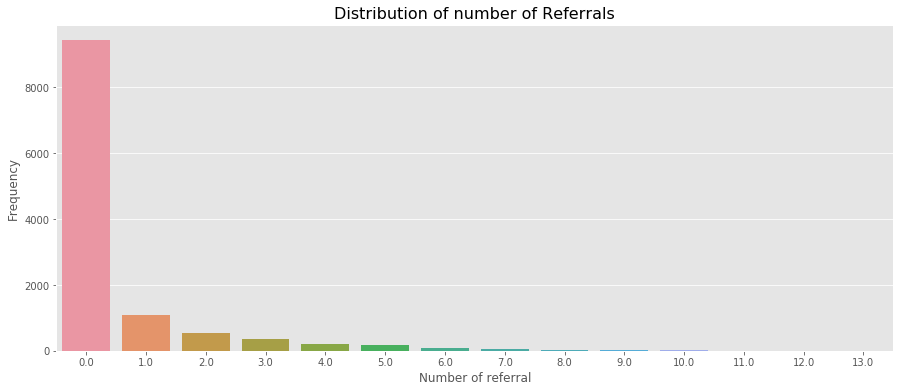

In [380]:
# This feature denotes the impact of an inviter as an influencer. The inviter is the person who recommend the 
# system to a user. If a user has been invited by the inviter who has attracted many users (high num_referrals), 
# this feature will be marked as "L" (large).
fig, ax = plt.subplots(figsize = (15,6))
sns.countplot(user.num_referrals, ax =ax)
plt.title("Distribution of number of Referrals", fontsize = 16)
plt.xlabel("Number of referral")
plt.ylabel("Frequency")


In [381]:
def get_Ref_size(x):
    
    size = "M" # default size
    if x >= 5:
        size = "L"
    elif x <= 1:
        size = "S"
    return size

invited["ref_size"] = invited.num_referrals.apply(get_Ref_size)
invited.head()

,object_id,num_referrals,ref_size
0,0.0,5583,L
1,10741.0,13,L
2,2527.0,12,L
3,1525.0,11,L
4,2308.0,11,L


In [382]:
# We can drop the first row as it is not informative since there is no object_id as 0
invited = invited.drop(0, axis = 0)

In [383]:
invited.head()

,object_id,num_referrals,ref_size
1,10741.0,13,L
2,2527.0,12,L
3,1525.0,11,L
4,2308.0,11,L
5,11770.0,11,L


In [384]:
invite_dict = dict(zip(invited.object_id, invited.ref_size))
invite_dict[2308] # checking key value pairs

'L'

In [385]:
# Now we will use the inivted table's object_id as key and return ref_size as value

user["ref_size"] = user.invited_by_user_id.map(invite_dict)

In [386]:
user["ref_size"] = user["ref_size"].fillna("Not_invited")
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,firstLogin_time,daysDiff,email_domain,length_usage,num_referrals,ref_size
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,2014-04-22 03:53:30,0,yahoo.com,0,0.0,S
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,2013-11-15 03:45:04,0,gustr.com,136,0.0,M
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,2013-03-19 23:14:52,0,gustr.com,0,1.0,L
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,2013-05-22 08:09:28,1,yahoo.com,1,0.0,L
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,2013-01-22 10:14:20,5,yahoo.com,5,0.0,L


#### organisational id impact

In [392]:
org = pd.DataFrame(user.org_id.value_counts()).reset_index()
org.columns = ["org_id", "num_org"]
org.head()

,org_id,num_org
0,0,319
1,1,233
2,2,201
3,3,168
4,4,159


Text(0, 0.5, 'Frequency of organization')

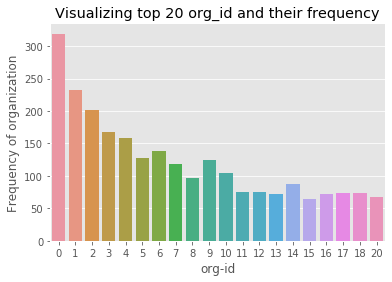

In [393]:
sns.barplot(x = org.org_id[:20], y= org.num_org[:20])
plt.title("Visualizing top 20 org_id and their frequency")
plt.xlabel("org-id")
plt.ylabel("Frequency of organization")

In [394]:
def getOrgSize(x):
    size = "Few"
    if x >= 200:
        size = "Extreme"
    elif x >= 100:
        size = "Big"
    elif x >= 50:
        size = "Moderate"
    elif x >= 10:
        size = "Small"
    return size

org["org_size"] = org.num_org.apply(getOrgSize)

In [395]:
org.head()

#Now we don't know if org_id = 0 is actually an org_id

,org_id,num_org,org_size
0,0,319,Extreme
1,1,233,Extreme
2,2,201,Extreme
3,3,168,Big
4,4,159,Big


In [396]:
org_dict = dict(zip(org.org_id, org.num_org))
org_size_dict = dict(zip(org.org_id, org.org_size))

user["org_size_num"] = user.org_id.map(org_dict)
user["org_size_cat"] = user.org_id.map(org_size_dict)

In [397]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,firstLogin_time,daysDiff,email_domain,length_usage,num_referrals,ref_size,org_size_num,org_size_cat
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,2014-04-22 03:53:30,0,yahoo.com,0,0.0,S,75,Moderate
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,2013-11-15 03:45:04,0,gustr.com,136,0.0,M,233,Extreme
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,2013-03-19 23:14:52,0,gustr.com,0,1.0,L,32,Small
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,2013-05-22 08:09:28,1,yahoo.com,1,0.0,L,233,Extreme
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,2013-01-22 10:14:20,5,yahoo.com,5,0.0,L,16,Small


### EDA

In [398]:
# Univariate Analysis

column_plots = ['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'invited_by_user_id',
       'daysDiff', 'email_domain', 'length_usage',
       'num_referrals', 'ref_size', 'org_size_num', 'org_size_cat']

In [399]:
import math


def distribution_plot(dataset, cols = 2, width = 20, height = 30, hspace = 0.2, wspace = 0.5):
    plt.style.use("ggplot")
    fig = plt.figure(figsize = (width, height))
    fig.subplots_adjust(left = None, top = None, bottom = None, right = None, wspace = wspace, hspace = hspace)
    rows = math.ceil(dataset.shape[1]/cols)
    for i, col in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(col)
        plt.tight_layout()
                    
        if col in (["daysDiff", "length_usage", "num_referrals", "org_size_num", "invited_by_user_id"]) : # for numerical columns
            # g = sns.distplot(dataset[col],  bw = 1.5)
            graph = sns.kdeplot(dataset[col], bw=1.5)
            plt.xticks(rotation = 25)
            
        else : #for categorical columns
            graph = sns.countplot(y = col, data = dataset)
            plt.xticks(rotation = 25)

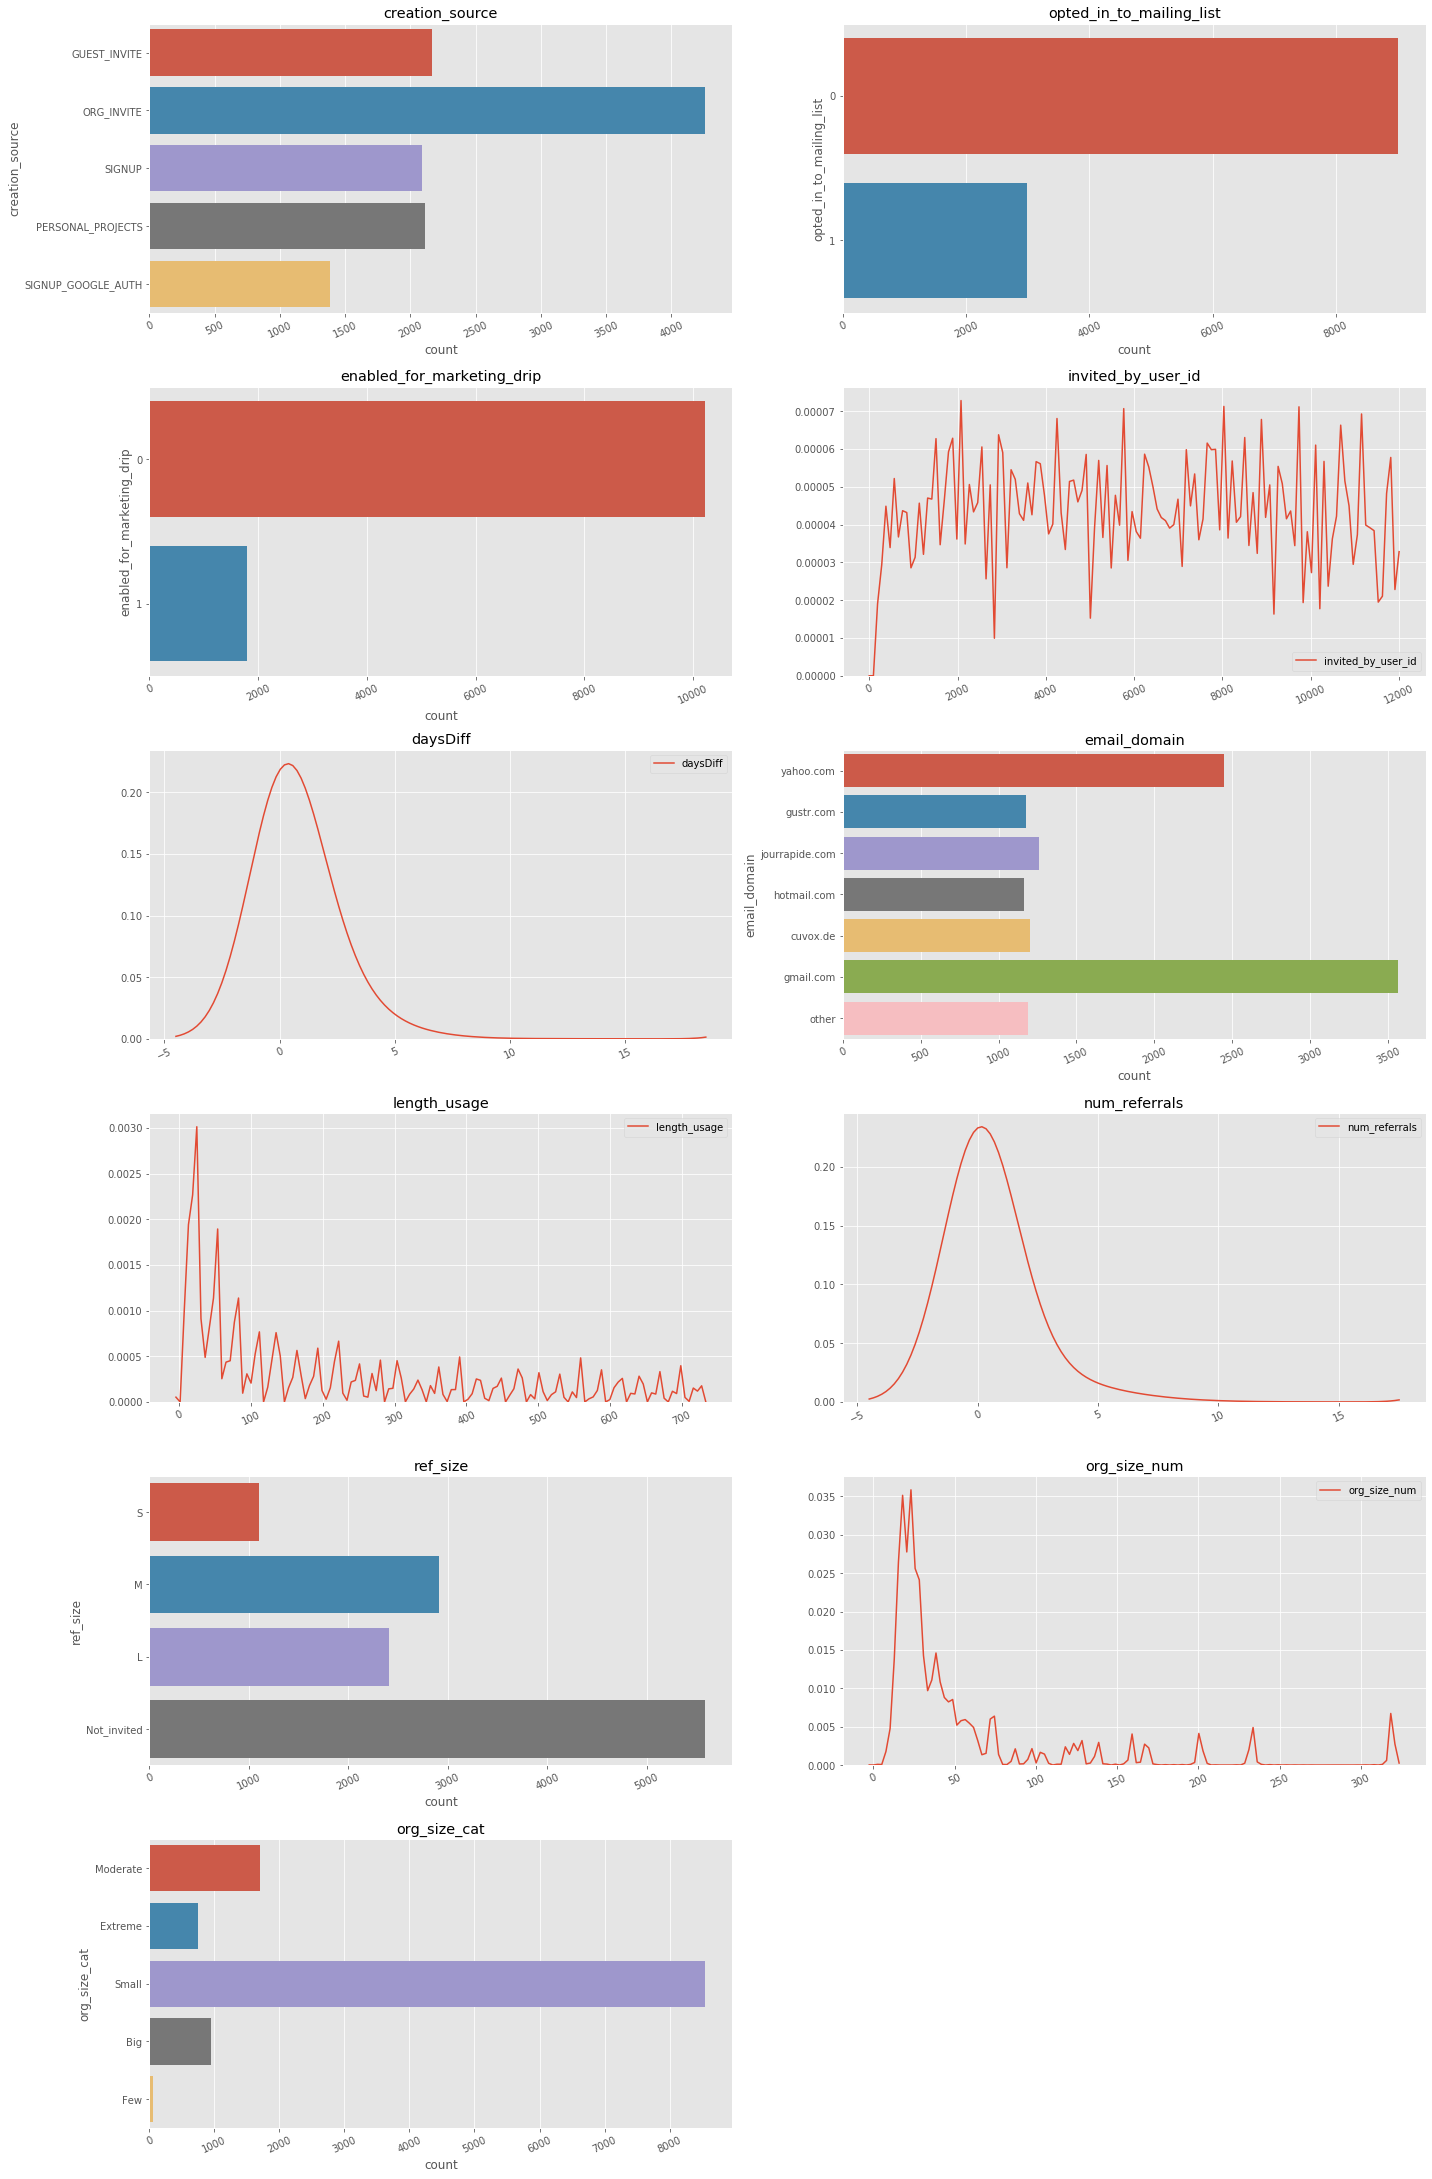

In [400]:
distribution_plot(user[column_plots])

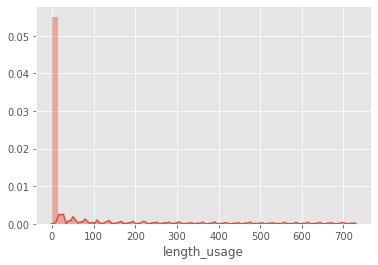

In [410]:
sns.distplot(user["length_usage"])

Text(0.5, 1.0, 'Visualizing the target column')

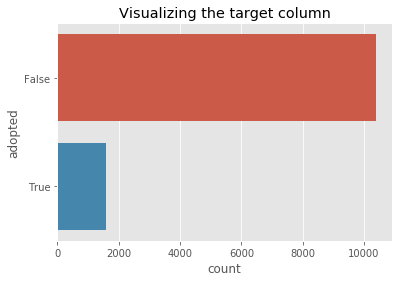

In [413]:
sns.countplot(data = user, y = "adopted")
plt.title("Visualizing the target column")

In [438]:
def bivariate_plot(dataset, cols, target):
    
    plt.style.use("ggplot")
    fig = plt.figure(figsize = (20, 20))
    fig.subplots_adjust(left = None, top = None, bottom = None, right = None, wspace = 0.5, hspace = 0.5)
    
    rows = math.ceil(dataset.shape[1]/cols)
    
    for i, col in enumerate(dataset.columns):
        if col != "adopted":
            ax = fig.add_subplot(rows, cols, i+1)
            ax.set_title(col)
            plt.tight_layout()
            graph = sns.countplot(y = col, data = dataset, hue = "adopted")
            plt.xticks(rotation = 25)
        


In [440]:
col_plot = ["creation_source", "opted_in_to_mailing_list", "enabled_for_marketing_drip","email_domain",
            "ref_size", "org_size_cat", "adopted"]

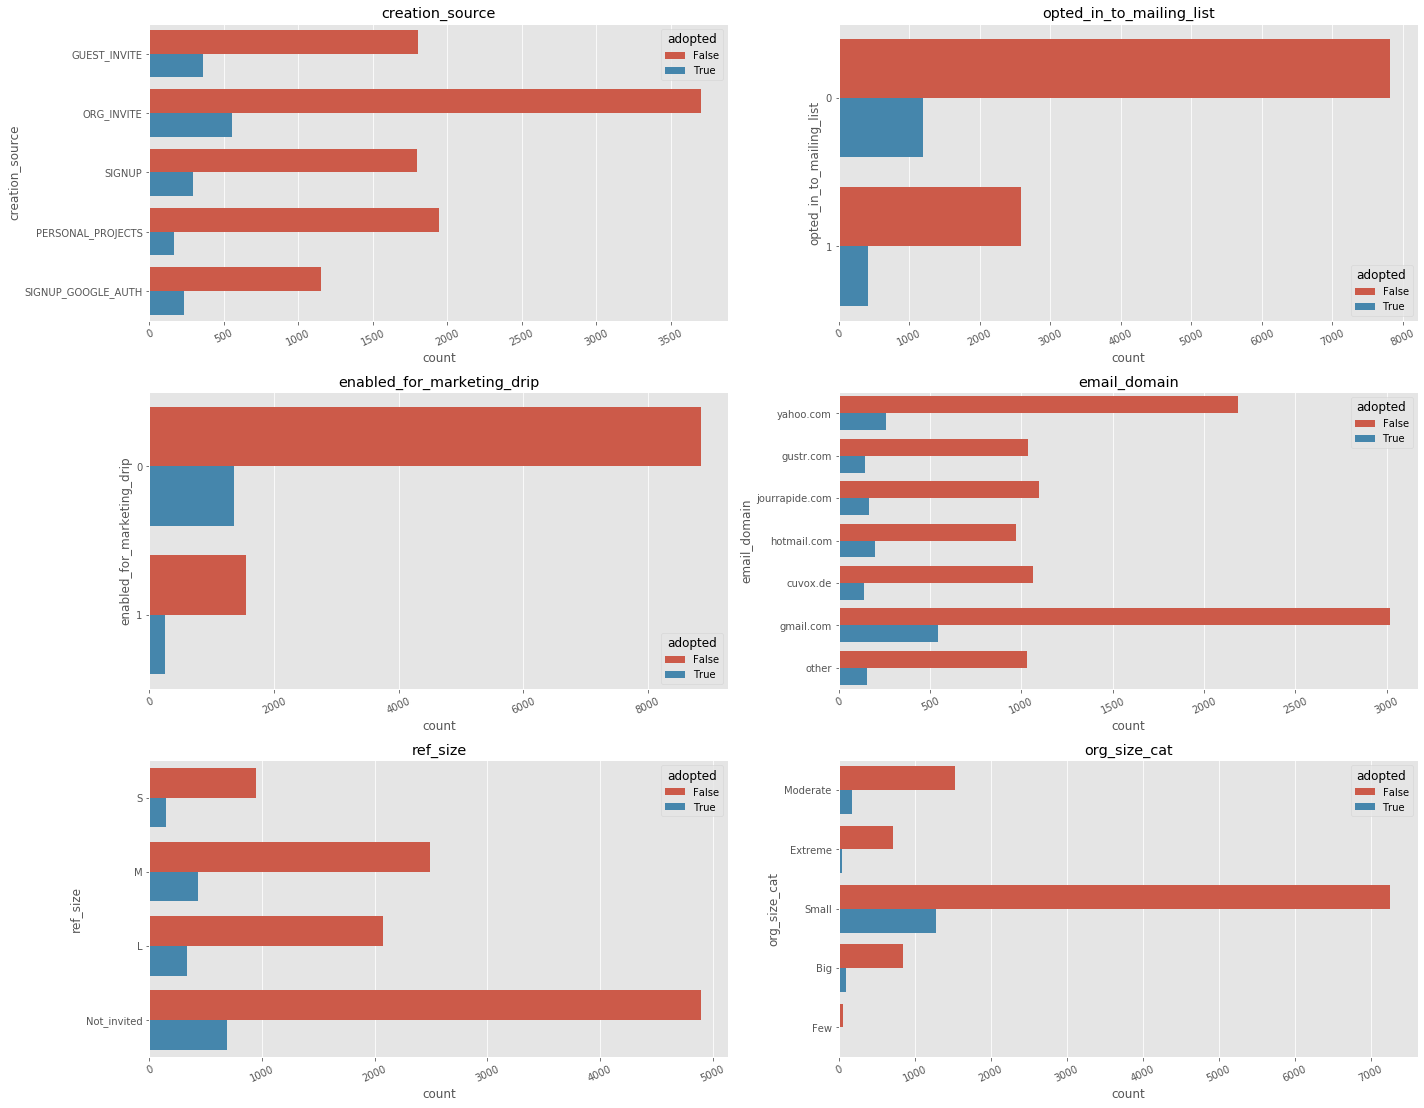

In [441]:
bivariate_plot(dataset = user[col_plot], cols = 2, target = "adopted")

In [454]:
#temp_plot = user[["firstLogin_time", "daysDiff"]]
#temp_plot = temp_plot.set_index("firstLogin_time")
#temp_plot.head()

In [453]:
# plt.figure(figsize = (20, 10))
#temp_plot.loc["2013-01", "daysDiff"].plot()

### Feature Encoding

In [457]:
no_need_cols = ["object_id", "creation_time", "name", "email", "last_session_creation_time", "org_id", "invited_by_user_id",
               "firstLogin_time", "adopted", "org_size_num"]

y = user["adopted"]
x = user.drop(no_need_cols, axis = 1)

In [458]:
x.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,daysDiff,email_domain,length_usage,num_referrals,ref_size,org_size_cat
0,GUEST_INVITE,1,0,0,yahoo.com,0,0.0,S,Moderate
1,ORG_INVITE,0,0,0,gustr.com,136,0.0,M,Extreme
2,ORG_INVITE,0,0,0,gustr.com,0,1.0,L,Small
3,GUEST_INVITE,0,0,1,yahoo.com,1,0.0,L,Extreme
4,GUEST_INVITE,0,0,5,yahoo.com,5,0.0,L,Small


In [459]:
y[:5]

0    False
1     True
2    False
3    False
4    False
Name: adopted, dtype: bool

In [464]:
cat_cols = ["creation_source", "opted_in_to_mailing_list", "enabled_for_marketing_drip",
            "email_domain", "ref_size", "org_size_cat"]

# We are using get_dummies on these columns because they do not follow any ordering (except ref_size and org_size_cat) 
# and dropping first to avoid multicollinearity

# To note that, ref_size and org_size_cat do follow ordering and we might use LabelEncoder for them but the amount of
# difference between these values are not known. For e.g how much big is L from M or how much big is Extreme from Moderate.
# Hence, to avoid any scaling issues, we may as well dummy encode them.

X_encoded = pd.get_dummies(x, columns = cat_cols,  drop_first = True)
X_encoded.head()

,daysDiff,length_usage,num_referrals,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_1,enabled_for_marketing_drip_1,email_domain_gmail.com,...,email_domain_jourrapide.com,email_domain_other,email_domain_yahoo.com,ref_size_M,ref_size_Not_invited,ref_size_S,org_size_cat_Extreme,org_size_cat_Few,org_size_cat_Moderate,org_size_cat_Small
0,0,0,0.0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1,0,136,0.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,5,5,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [465]:
# Encoding target variable

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(y)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

### Feature Importance

In [471]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_encoded,y)

feature_imp = pd.Series(rfc.feature_importances_, index = X_encoded.columns).sort_values(ascending = False)


Text(0.5, 1.0, 'Visualizing Feature importance')

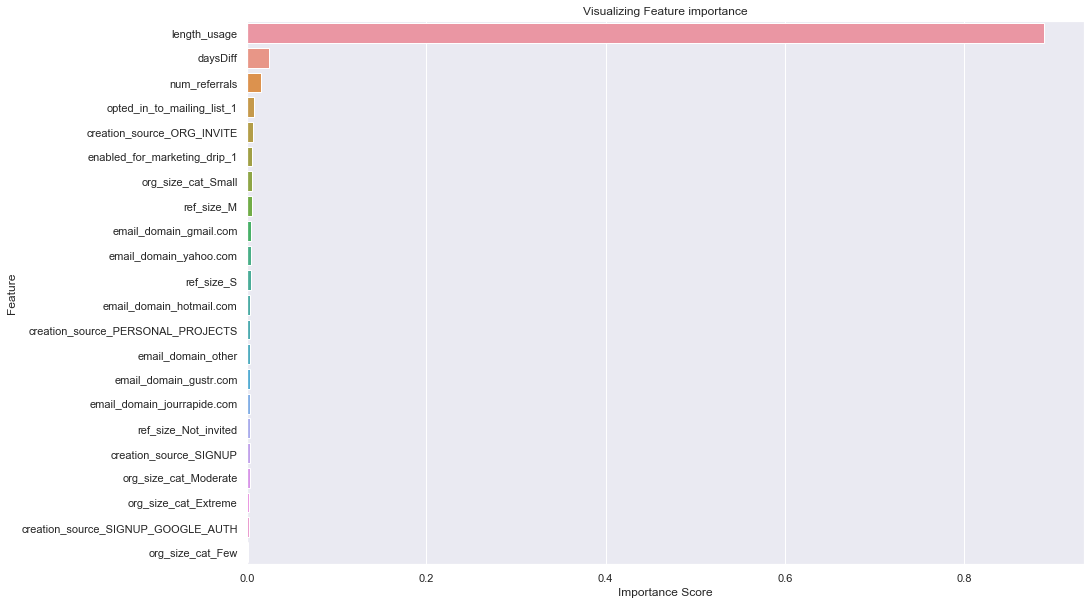

In [474]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Visualizing Feature importance")

In [477]:
# As visible, the length_usage variable is majorly able to predict the adopted variable.
# We can solidify our finding by using ExtraTreeClassifier for feature importance

In [476]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(X_encoded, y)

imp_feature2 = pd.Series(etc.feature_importances_, index = X_encoded.columns).sort_values(ascending = False)


Text(0.5, 1.0, 'Visualizing Feature Importance')

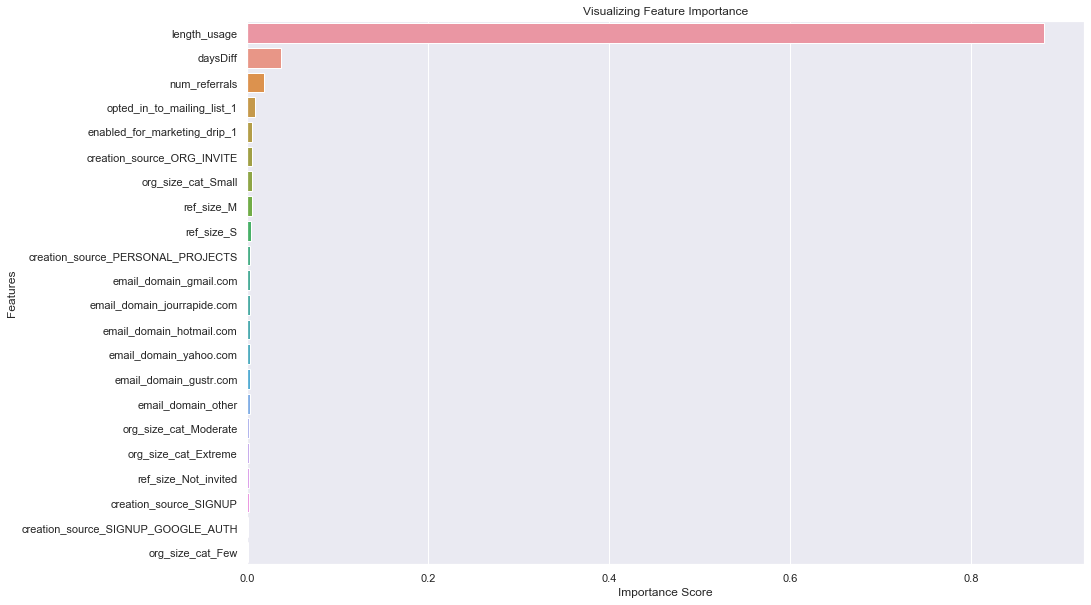

In [478]:
sns.barplot(y = imp_feature2.index, x = imp_feature2)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Feature Importance")

In [479]:
feature_imp

length_usage                          0.889554
daysDiff                              0.024004
num_referrals                         0.014885
opted_in_to_mailing_list_1            0.007515
creation_source_ORG_INVITE            0.006187
enabled_for_marketing_drip_1          0.005656
org_size_cat_Small                    0.005551
ref_size_M                            0.005173
email_domain_gmail.com                0.004291
email_domain_yahoo.com                0.003975
ref_size_S                            0.003867
email_domain_hotmail.com              0.003654
creation_source_PERSONAL_PROJECTS     0.003594
email_domain_other                    0.003133
email_domain_gustr.com                0.003053
email_domain_jourrapide.com           0.003027
ref_size_Not_invited                  0.002803
creation_source_SIGNUP                0.002791
org_size_cat_Moderate                 0.002648
org_size_cat_Extreme                  0.002005
creation_source_SIGNUP_GOOGLE_AUTH    0.001815
org_size_cat_

In [481]:
imp_feature2

length_usage                          0.880995
daysDiff                              0.037052
num_referrals                         0.018823
opted_in_to_mailing_list_1            0.008187
enabled_for_marketing_drip_1          0.005834
creation_source_ORG_INVITE            0.005241
org_size_cat_Small                    0.005009
ref_size_M                            0.005004
ref_size_S                            0.003716
creation_source_PERSONAL_PROJECTS     0.003452
email_domain_gmail.com                0.002980
email_domain_jourrapide.com           0.002910
email_domain_hotmail.com              0.002891
email_domain_yahoo.com                0.002838
email_domain_gustr.com                0.002692
email_domain_other                    0.002651
org_size_cat_Moderate                 0.002488
org_size_cat_Extreme                  0.002161
ref_size_Not_invited                  0.001697
creation_source_SIGNUP                0.001612
creation_source_SIGNUP_GOOGLE_AUTH    0.000932
org_size_cat_

As we can observe, both the models choose length_usage as quite an significant feature to predict adopted target variable with only a little difference in the importance score.

In [482]:
## Feature Correlation

# Correlation is a measure of how much two random variables change together. 
# Features should be uncorrelated with each other and highly correlated to the feature we are trying to predict.

corr_xy = pd.concat([X_encoded, y], axis = 1)

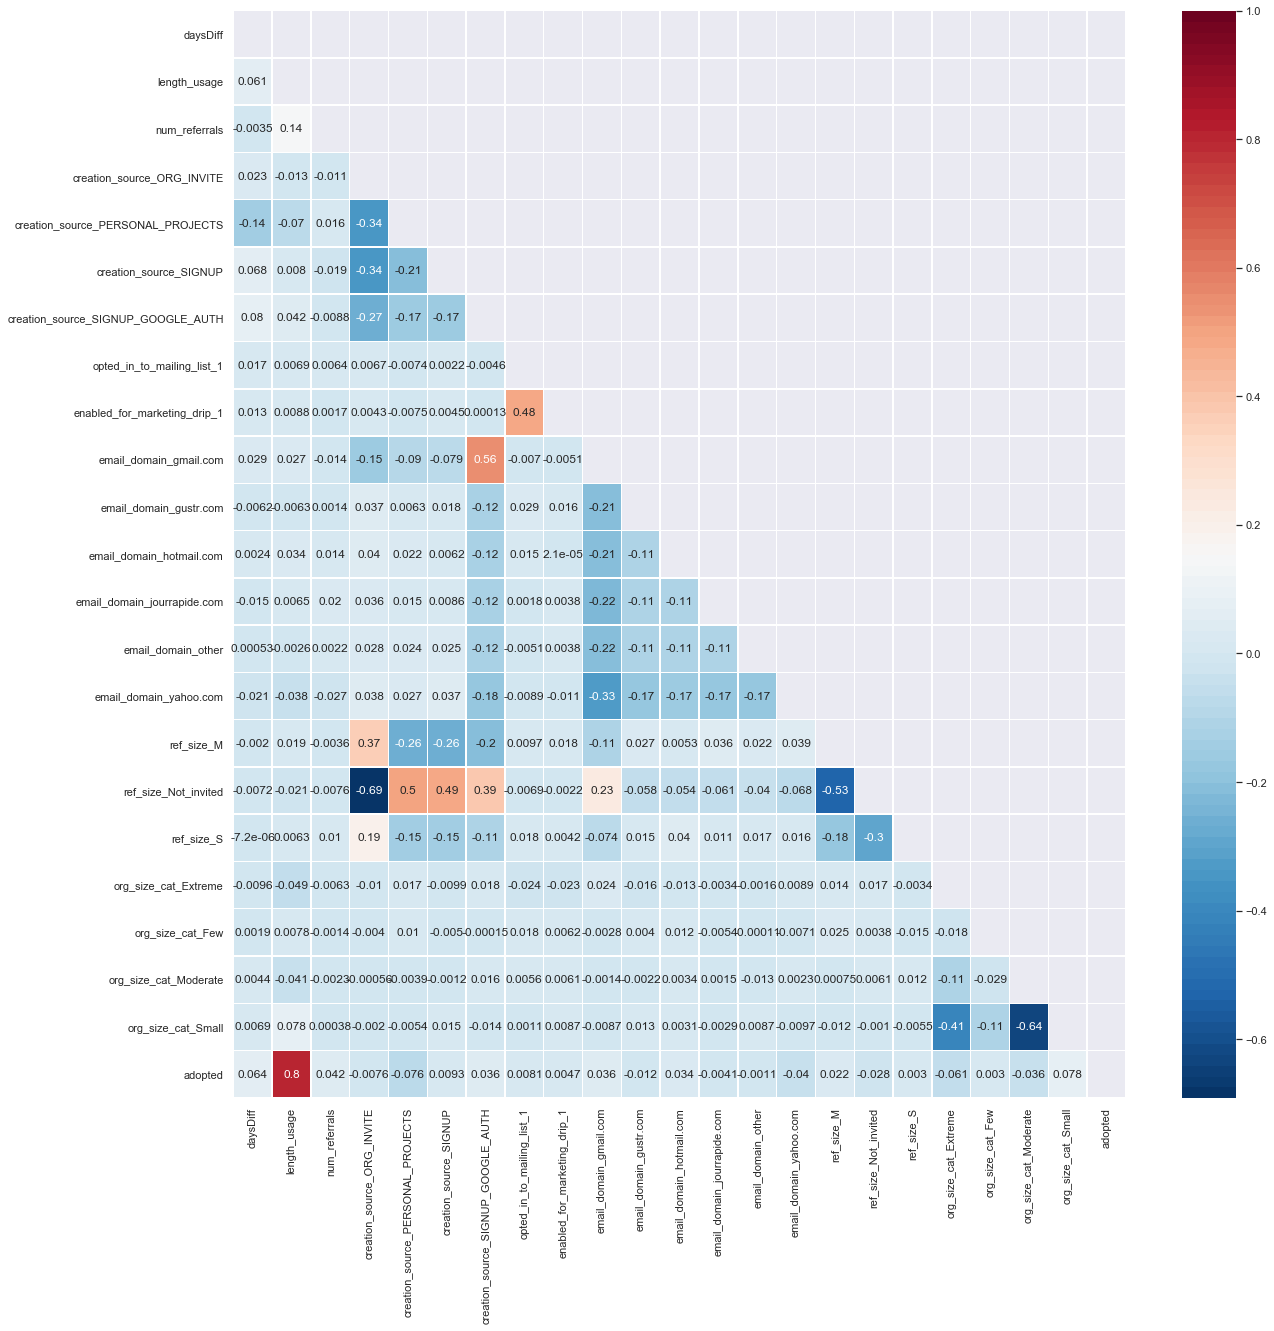

In [497]:
sns.set(rc={'figure.figsize':(20, 20)})

mask = np.zeros_like(corr_xy.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_xy.corr(), annot = True, cmap=sns.color_palette("RdBu_r", 100), mask = mask, linewidth = 0.5)

In [498]:
# As observed before, length_usage is giving significant correlation with target variable.

# opted_for_mailing_list and enabled_for_marketing_drip seems to be correlated which is not surprising since people tend to
# opt for both the options if they want to know more information about any upcoming news/campaign.

# email_domain_gmail.com and creation_source_SIGNUP_GOOGLE_AAuth also tend to relate which is obvious.

# The people who were not invited i.e. ref_size_Not_invited tend to login for their personal projects.

# We will not remove any columns as of now since they contain some kind of information.


In [500]:
final_df = X_encoded.join(y)
final_df.to_csv("final_df.csv")

### Modelling

In [2]:
df = pd.read_csv("final_df.csv")
df.head()

,Unnamed: 0,daysDiff,length_usage,num_referrals,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_1,enabled_for_marketing_drip_1,...,email_domain_other,email_domain_yahoo.com,ref_size_M,ref_size_Not_invited,ref_size_S,org_size_cat_Extreme,org_size_cat_Few,org_size_cat_Moderate,org_size_cat_Small,adopted
0,0,0,0,0.0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,False
1,1,0,136,0.0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,True
2,2,0,0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
3,3,1,1,0.0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,False
4,4,5,5,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,False


In [3]:
df.shape

(12000, 24)

In [7]:
df = df.drop("Unnamed: 0", axis = 1)

In [9]:
y = df["adopted"]
X = df.drop("adopted", axis = 1)

In [10]:
X.head()

,daysDiff,length_usage,num_referrals,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_1,enabled_for_marketing_drip_1,email_domain_gmail.com,...,email_domain_jourrapide.com,email_domain_other,email_domain_yahoo.com,ref_size_M,ref_size_Not_invited,ref_size_S,org_size_cat_Extreme,org_size_cat_Few,org_size_cat_Moderate,org_size_cat_Small
0,0,0,0.0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1,0,136,0.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,5,5,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [11]:
y[:5]

0    False
1     True
2    False
3    False
4    False
Name: adopted, dtype: bool

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix, f1_score

SEED = 44

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = SEED)

print("Total train records : {}".format(len(y_train)))
print("Total test records : {}".format(len(y_test)))

Total train records : 9000
Total test records : 3000


In [19]:
list_of_model = ["LogisticRegression", "SVC", "RandomForestClassifier", "XGBoost"]
score_table = pd.DataFrame(index = list_of_model, 
                           columns = ["train_accuracy", "train_F1_score", "test_accuracy", "test_F1_score"])


In [20]:
def compute_results(algo, pred_train, pred_test):
    
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    score_table.loc[algo,:] = accuracy_train, f1_train, accuracy_test, f1_test
    
    print("Confusion Matrix results for {} are: \n \n {}".format(algo, classification_report(y_test, pred_test)))

#### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression

logit = LogisticRegression(max_iter = 500)
logit.fit(X_train, y_train)
pred_train = logit.predict(X_train)
pred_test = logit.predict(X_test)

compute_results("LogisticRegression", pred_train, pred_test)

Confusion Matrix results for LogisticRegression are: 
 
               precision    recall  f1-score   support

       False       0.98      0.99      0.99      2602
        True       0.94      0.88      0.91       398

    accuracy                           0.98      3000
   macro avg       0.96      0.93      0.95      3000
weighted avg       0.98      0.98      0.98      3000



#### SVC

In [23]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

compute_results("SVC", pred_train, pred_test)

Confusion Matrix results for SVC are: 
 
               precision    recall  f1-score   support

       False       0.98      0.99      0.99      2602
        True       0.95      0.87      0.91       398

    accuracy                           0.98      3000
   macro avg       0.97      0.93      0.95      3000
weighted avg       0.98      0.98      0.98      3000



#### Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

compute_results("RandomForestClassifier", pred_train, pred_test)

Confusion Matrix results for RandomForestClassifier are: 
 
               precision    recall  f1-score   support

       False       0.98      0.99      0.98      2602
        True       0.90      0.89      0.90       398

    accuracy                           0.97      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.97      0.97      0.97      3000



#### XGBOOST

In [25]:
from xgboost.sklearn import XGBClassifier


xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred_train = xgb.predict(X_train)
pred_test = xgb.predict(X_test)

compute_results("XGBoost", pred_train, pred_test)

Confusion Matrix results for XGBoost are: 
 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98      2602
        True       0.89      0.87      0.88       398

    accuracy                           0.97      3000
   macro avg       0.93      0.92      0.93      3000
weighted avg       0.97      0.97      0.97      3000



In [26]:
print(score_table)

                       train_accuracy train_F1_score test_accuracy  \
LogisticRegression           0.974778       0.901944      0.976333   
SVC                          0.974444       0.900519      0.976333   
RandomForestClassifier       0.999333       0.997506      0.972333   
XGBoost                      0.993778        0.97651      0.967667   

                       test_F1_score  
LogisticRegression          0.907672  
SVC                         0.906702  
RandomForestClassifier       0.89507  
XGBoost                     0.876747  


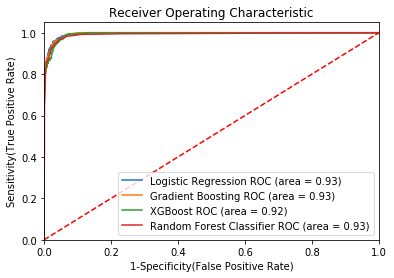

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(max_iter = 500),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'XGBoost',
    'model': XGBClassifier(),
},
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(),
}
    
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

### Conclusion

In the feature correlation, we have drawn the heat map and found that there are strong correlation between adopted users and length_usage. The length usage denotes the days from the first account creation to the last login time. This feature represents the extentto which a user consistenly has been using the services.

In the feature impotance analysis, we use inbuilt class feature_importances of tree based classifiers (e.g., RandomForestClassifier and ExtraTreesClassifier). The results of the order of important features is same in both tree based classifiers even thought the coefficients are different. Likewise the results in the feature correlation, we see that the length_usage is the strongest indicator for explaining the adopted users. The feature importances are 0.889 (RandomForestClassifier) and 0.880 (ExtraTreesClassifier).

Next, the other significant features are: daysDiff, num_referrals, opted_in_to_mailing_list_1, enabled_for_marketing_drip_1, creation_source_ORG_INVITE. Those indicate that the frequency of organizational invite, the days between initial login and first creation, the number of user's referrals, and the subcription in the mailing list are all impacting factors. These are related to customer's engagement to services or products.

For the model results, we obtain the best test accuracy from the Logistic Regression model and SVC (both having 97.23% accuracy).